In [1]:
# Import required libraries
import os
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# Check CUDA availability
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("Warning: Running on CPU. Request GPU node for faster inference.")

PyTorch Version: 2.7.1+cu118
CUDA Available: True
CUDA Device: NVIDIA H100 80GB HBM3
Number of GPUs: 1
CUDA Available: True
CUDA Device: NVIDIA H100 80GB HBM3
Number of GPUs: 1


# Cryptocurrency Sentiment Analysis - Multimodal Pipeline

Implementation of the Cross-Modal Sentiment Analysis Pipeline following the paper's methodology:
1. **Video Processing**: Extract frames and visual features
2. **Audio Processing**: Extract speech and convert to text
3. **Text Processing**: Extract visible text (OCR) from frames
4. **Emotion Recognition**: Analyze facial expressions and sentiment
5. **Chain-of-Thoughts LLM**: Combine all modalities for final sentiment prediction

This approach enhances cryptocurrency volatility prediction using multimodal features from DogeCoin videos.

## Step 1: Install Required Dependencies

Install all necessary packages for multimodal analysis: video processing, speech recognition, OCR, and emotion detection.

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Create necessary directories
import os
os.makedirs("./videos", exist_ok=True)
os.makedirs("./results", exist_ok=True)
os.makedirs("./temp", exist_ok=True)

print("✓ All dependencies installed!")
print("✓ Dependency conflicts resolved!")
print("✓ Directories created: ./videos, ./results, ./temp")

✓ All dependencies installed!
✓ Dependency conflicts resolved!
✓ Directories created: ./videos, ./results, ./temp


## Step 2: Simplified Sentiment Analysis

Using a simplified approach that doesn't require video frame extraction, audio processing, OCR, or emotion detection.
This provides a baseline for sentiment analysis that can be enhanced when additional tools become available.


In [3]:
import torch
import numpy as np
from pathlib import Path
from typing import Dict, List

# Check if required packages are available
try:
    import cv2
    print("✓ OpenCV available")
except ImportError:
    print("⚠ OpenCV not available - install with: pip install opencv-python")

try:
    from transformers import pipeline, CLIPProcessor, CLIPModel
    print("✓ Transformers available")
except ImportError:
    print("⚠ Transformers not available - install with: pip install transformers")

print("\nNote: This implementation uses:")
print("  - OpenCV for video frame extraction")
print("  - CLIP (OpenAI) for visual sentiment analysis")
print("  - BERTweet for text sentiment analysis")


✓ OpenCV available
✓ Transformers available

Note: This implementation uses:
  - OpenCV for video frame extraction
  - CLIP (OpenAI) for visual sentiment analysis
  - BERTweet for text sentiment analysis
✓ Transformers available

Note: This implementation uses:
  - OpenCV for video frame extraction
  - CLIP (OpenAI) for visual sentiment analysis
  - BERTweet for text sentiment analysis


## Step 3: CLIP-Based Video Sentiment Analyzer

Implements a CLIP-based analyzer that extracts frames from videos and analyzes visual sentiment using OpenAI's CLIP model.


In [4]:
import re
from datetime import datetime
from transformers import pipeline
import cv2

class CLIPVideoSentimentAnalyzer:
    """
    Video sentiment analyzer using CLIP (Contrastive Language-Image Pre-training)
    Extracts frames from videos and analyzes visual sentiment using OpenAI's CLIP model
    """
    
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print("Initializing CLIP Video Sentiment Analyzer...")
        
        # Load CLIP for visual sentiment analysis
        try:
            from transformers import CLIPProcessor, CLIPModel
            self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
            self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
            print("✓ CLIP model loaded for visual analysis!")
        except Exception as e:
            print(f"⚠ Could not load CLIP model: {e}")
            self.clip_model = None
            self.clip_processor = None
        
        print("✓ CLIP Video Sentiment Analyzer initialized!")
    
    @staticmethod
    def extract_video_date(filename: str) -> str:
        """Extract date from video filename"""
        patterns = [
            r'(\d{4}-\d{2}-\d{2})',  # YYYY-MM-DD
            r'(\d{8})',               # YYYYMMDD
            r'(\d{4}_\d{2}_\d{2})'   # YYYY_MM_DD
        ]
        
        for pattern in patterns:
            match = re.search(pattern, filename)
            if match:
                date_str = match.group(1).replace('_', '-')
                if len(date_str) == 8:
                    date_str = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"
                return date_str
        
        return filename
    
    def extract_frames(self, video_path: str, num_frames: int = 5):
        """Extract frames from video using OpenCV"""
        try:
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            if total_frames == 0:
                print(f"No frames found in video")
                return []
            
            # Sample frames uniformly across the video
            frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
            frames = []
            
            for idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if ret:
                    # Convert BGR to RGB for CLIP
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame)
            
            cap.release()
            return frames
            
        except Exception as e:
            print(f"Error extracting frames: {e}")
            return []
    
    def analyze_visual_sentiment_with_clip(self, frames):
        """Analyze sentiment from video frames using CLIP zero-shot classification"""
        if not self.clip_model or not self.clip_processor or len(frames) == 0:
            return 0.0, "No visual analysis"
        
        try:
            # Define cryptocurrency sentiment labels for CLIP
            labels = [
                "positive cryptocurrency news, bullish market, growth, moon, pump",
                "negative cryptocurrency news, bearish market, decline, crash, dump", 
                "neutral cryptocurrency discussion, stable market, sideways"
            ]
            
            scores = []
            for frame in frames:
                # Prepare inputs for CLIP
                inputs = self.clip_processor(
                    text=labels, 
                    images=frame, 
                    return_tensors="pt", 
                    padding=True
                ).to(self.device)
                
                # Get CLIP predictions
                outputs = self.clip_model(**inputs)
                logits_per_image = outputs.logits_per_image
                probs = logits_per_image.softmax(dim=1).cpu().detach().numpy()[0]
                
                # Calculate sentiment score: positive - negative
                sentiment_score = probs[0] - probs[1]
                scores.append(sentiment_score)
            
            avg_score = np.mean(scores)
            return avg_score, f"CLIP visual analysis from {len(frames)} frames"
            
        except Exception as e:
            print(f"Error in CLIP visual sentiment: {e}")
            return 0.0, f"Error: {str(e)}"
    
    def generate_sentiment_score(self, video_path: str) -> Dict:
        """
        Generate sentiment score from video content using CLIP
        """
        # Extract frames from video
        frames = self.extract_frames(video_path, num_frames=5)
        
        if len(frames) == 0:
            # Fallback: Use filename-based heuristic
            filename = Path(video_path).name.lower()
            if any(word in filename for word in ['pump', 'moon', 'bull', 'up', 'gain', 'profit', 'rise']):
                sentiment_score = 0.5
            elif any(word in filename for word in ['dump', 'crash', 'bear', 'down', 'loss', 'drop', 'fall']):
                sentiment_score = -0.5
            else:
                sentiment_score = 0.0
            method = "Filename heuristic (no frames extracted)"
        else:
            # Analyze visual content with CLIP
            sentiment_score, method = self.analyze_visual_sentiment_with_clip(frames)
        
        # Classify based on score
        if sentiment_score > 0.2:
            classification = 'POSITIVE'
            confidence = 'HIGH' if sentiment_score > 0.4 else 'MEDIUM'
        elif sentiment_score < -0.2:
            classification = 'NEGATIVE'
            confidence = 'HIGH' if sentiment_score < -0.4 else 'MEDIUM'
        else:
            classification = 'NEUTRAL'
            confidence = 'MEDIUM'
        
        return {
            'sentiment_score': float(sentiment_score),
            'sentiment_class': classification,
            'confidence': confidence,
            'method': method,
            'num_frames_analyzed': len(frames),
            'timestamp': datetime.now().isoformat()
        }
    
    def analyze_video(self, video_path: str) -> Dict:
        """
        Analyze a single video file
        """
        print(f"Processing: {Path(video_path).name}")
        
        result = {
            'date': self.extract_video_date(Path(video_path).name),
            'video_path': str(video_path),
        }
        
        # Generate sentiment using CLIP
        sentiment = self.generate_sentiment_score(video_path)
        result.update(sentiment)
        
        return result
    
    def batch_analyze_videos(self, video_dir: str, output_csv: str = './results/sentiment_analysis.csv', 
                            consolidate_by_date: bool = True):
        """
        Analyze all videos in a directory using CLIP
        
        Args:
            video_dir: Directory containing video files
            output_csv: Path to save results CSV
            consolidate_by_date: If True, consolidates multiple videos from the same date into one entry
        """
        video_dir = Path(video_dir)
        video_extensions = ['*.mp4', '*.avi', '*.mov', '*.mkv', '*.webm']
        
        video_files = []
        for ext in video_extensions:
            video_files.extend(list(video_dir.glob(ext)))
        
        video_files = sorted(video_files)
        
        print("\n" + "="*80)
        print(f"CLIP-BASED VIDEO SENTIMENT ANALYSIS")
        print(f"Found {len(video_files)} videos to process")
        if consolidate_by_date:
            print(f"Mode: CONSOLIDATING videos by date")
        print("="*80 + "\n")
        
        if len(video_files) == 0:
            print(f"No videos found in {video_dir}")
            return pd.DataFrame()
        
        if consolidate_by_date:
            # Group videos by date
            videos_by_date = {}
            for video_path in video_files:
                date = self.extract_video_date(video_path.name)
                if date not in videos_by_date:
                    videos_by_date[date] = []
                videos_by_date[date].append(video_path)
            
            print(f"Found {len(videos_by_date)} unique dates with videos")
            for date, vids in sorted(videos_by_date.items()):
                print(f"  {date}: {len(vids)} video(s)")
            print()
            
            # Process each date
            results = []
            date_count = 0
            for date, date_videos in sorted(videos_by_date.items()):
                date_count += 1
                print(f"[{date_count}/{len(videos_by_date)}] Processing date: {date} ({len(date_videos)} videos)")
                
                # Analyze all videos for this date
                all_frames = []
                video_paths = []
                for video_path in date_videos:
                    print(f"  - Extracting frames from: {video_path.name}")
                    frames = self.extract_frames(str(video_path), num_frames=5)
                    all_frames.extend(frames)
                    video_paths.append(str(video_path))
                
                # Generate consolidated sentiment for all frames from this date
                if len(all_frames) > 0:
                    sentiment_score, method = self.analyze_visual_sentiment_with_clip(all_frames)
                    
                    # Classify based on score
                    if sentiment_score > 0.2:
                        classification = 'POSITIVE'
                        confidence = 'HIGH' if sentiment_score > 0.4 else 'MEDIUM'
                    elif sentiment_score < -0.2:
                        classification = 'NEGATIVE'
                        confidence = 'HIGH' if sentiment_score < -0.4 else 'MEDIUM'
                    else:
                        classification = 'NEUTRAL'
                        confidence = 'MEDIUM'
                    
                    result = {
                        'date': date,
                        'num_videos': len(date_videos),
                        'video_paths': '; '.join([Path(p).name for p in video_paths]),
                        'sentiment_score': float(sentiment_score),
                        'sentiment_class': classification,
                        'confidence': confidence,
                        'method': f"CLIP visual analysis from {len(all_frames)} total frames across {len(date_videos)} videos",
                        'num_frames_analyzed': len(all_frames),
                        'timestamp': datetime.now().isoformat()
                    }
                else:
                    # Fallback
                    result = {
                        'date': date,
                        'num_videos': len(date_videos),
                        'video_paths': '; '.join([Path(p).name for p in video_paths]),
                        'sentiment_score': 0.0,
                        'sentiment_class': 'NEUTRAL',
                        'confidence': 'LOW',
                        'method': 'No frames extracted',
                        'num_frames_analyzed': 0,
                        'timestamp': datetime.now().isoformat()
                    }
                
                results.append(result)
                print(f"  → Consolidated sentiment: {result['sentiment_class']} (score: {result['sentiment_score']:.3f})\n")
            
        else:
            # Original behavior: process each video separately
            results = []
            for i, video_path in enumerate(video_files, 1):
                print(f"[{i}/{len(video_files)}] ", end="")
                result = self.analyze_video(str(video_path))
                results.append(result)
        
        # Create DataFrame
        df = pd.DataFrame(results)
        
        # Save results
        df.to_csv(output_csv, index=False)
        
        print("\n" + "="*80)
        print(f"✓ ANALYSIS COMPLETE!")
        if consolidate_by_date:
            print(f"  Total unique dates processed: {len(df)}")
            print(f"  Total videos analyzed: {len(video_files)}")
            print(f"  Average videos per date: {len(video_files)/len(df):.1f}")
        else:
            print(f"  Total videos processed: {len(video_files)}")
        print(f"  Results saved to: {output_csv}")
        if len(df) > 0:
            print(f"  Average sentiment score: {df['sentiment_score'].mean():.3f}")
            print(f"  Sentiment distribution:")
            print(df['sentiment_class'].value_counts().to_string())
        print("="*80 + "\n")
        
        return df

print("✓ CLIPVideoSentimentAnalyzer class defined!")


✓ CLIPVideoSentimentAnalyzer class defined!


## Step 6: Run the Simplified Pipeline

Execute the simplified sentiment analysis on your DogeCoin videos.


In [5]:
# Initialize the CLIP-based sentiment analyzer
VIDEO_DIR = "./videos"  # Directory with your dated DogeCoin videos
OUTPUT_DIR = "./results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Run the CLIP-based sentiment analysis pipeline
print("="*80)
print("CLIP-BASED VIDEO SENTIMENT ANALYSIS PIPELINE")
print("="*80)

analyzer = CLIPVideoSentimentAnalyzer()

# Analyze all videos with date consolidation
# Set consolidate_by_date=True to combine multiple videos from the same date
# Set consolidate_by_date=False to process each video separately
results_df = analyzer.batch_analyze_videos(
    video_dir=VIDEO_DIR,
    output_csv=f"{OUTPUT_DIR}/sentiment_analysis.csv",
    consolidate_by_date=True  # Consolidate videos by date
)

# Display results if any videos were processed
if len(results_df) > 0:
    print("\n" + "="*80)
    print("SAMPLE RESULTS")
    print("="*80)
    if 'num_videos' in results_df.columns:
        # Consolidated view
        print(results_df[['date', 'num_videos', 'sentiment_score', 'sentiment_class', 'confidence', 'num_frames_analyzed']].head(10))
    else:
        # Individual video view
        print(results_df[['date', 'sentiment_score', 'sentiment_class', 'confidence', 'num_frames_analyzed']].head(10))
    
    print(f"\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    print(results_df['sentiment_score'].describe())
    print(f"\nSentiment Class Distribution:")
    print(results_df['sentiment_class'].value_counts())
    print(f"\nAverage frames analyzed per entry: {results_df['num_frames_analyzed'].mean():.1f}")
    if 'num_videos' in results_df.columns:
        print(f"Total videos consolidated: {results_df['num_videos'].sum()}")
        print(f"Unique dates: {len(results_df)}")
else:
    print("\n⚠ Warning: No video files found in", VIDEO_DIR)
    print("Please add video files to the ./videos/ directory")
    print("Expected naming: YYYY-MM-DD.mp4 (e.g., 2025-10-10.mp4)")



CLIP-BASED VIDEO SENTIMENT ANALYSIS PIPELINE
Initializing CLIP Video Sentiment Analyzer...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ CLIP model loaded for visual analysis!
✓ CLIP Video Sentiment Analyzer initialized!

CLIP-BASED VIDEO SENTIMENT ANALYSIS
Found 39 videos to process
Mode: CONSOLIDATING videos by date

Found 17 unique dates with videos
  2025-01-31: 2 video(s)
  2025-02-04: 2 video(s)
  2025-02-06: 6 video(s)
  2025-02-07: 2 video(s)
  2025-02-10: 1 video(s)
  2025-02-12: 1 video(s)
  2025-02-13: 1 video(s)
  2025-02-14: 5 video(s)
  2025-02-17: 1 video(s)
  2025-02-19: 2 video(s)
  2025-02-20: 1 video(s)
  2025-02-21: 3 video(s)
  2025-02-24: 1 video(s)
  2025-02-25: 2 video(s)
  2025-02-26: 3 video(s)
  2025-02-27: 3 video(s)
  2025-02-28: 3 video(s)

[1/17] Processing date: 2025-01-31 (2 videos)
  - Extracting frames from: 2025_01_31.mp4
  - Extracting frames from: 2025_01_31_1.mp4
  - Extracting frames from: 2025_01_31_1.mp4
  → Consolidated sentiment: NEGATIVE (score: -0.380)

[2/17] Processing date: 2025-02-04 (2 videos)
  - Extracting frames from: 2025_02_04.mp4
  → Consolidated sentiment: NEGA

## Visualization: Sentiment Score vs. Dogecoin Price Trend

Plot the sentiment scores over time alongside the actual Dogecoin price to visualize potential correlations.

✓ yfinance available
CREATING SENTIMENT VS PRICE VISUALIZATION

Fetching Dogecoin price data from 2025-01-30 to 2025-03-01...
✓ Fetched 30 days of Dogecoin price data
✓ Plot saved to: ./results/sentiment_vs_price.png


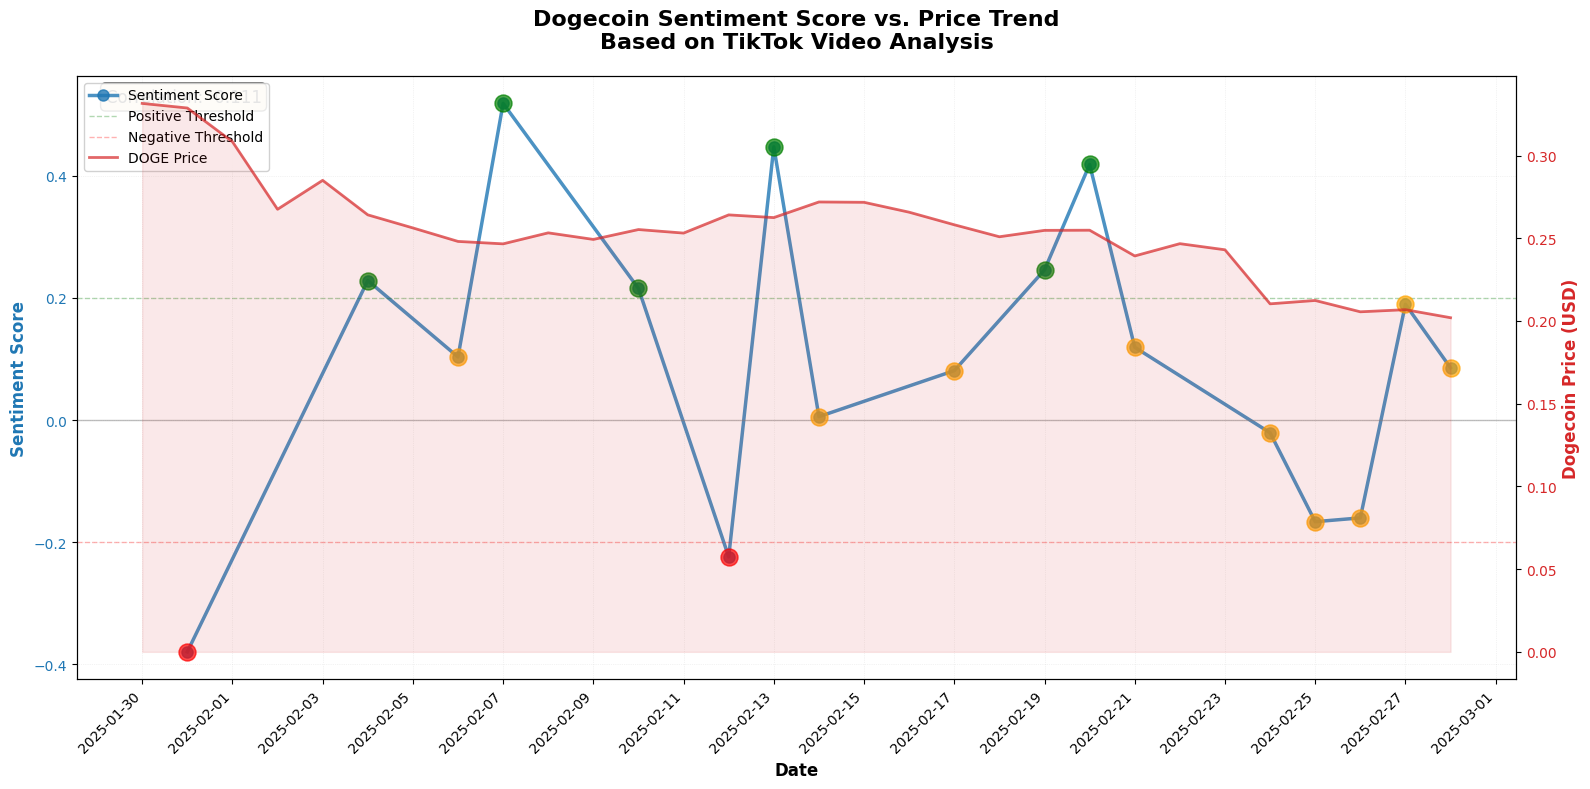


SENTIMENT VS PRICE SUMMARY

Sentiment Statistics:
  Mean sentiment: 0.100
  Std deviation:  0.244
  Min sentiment:  -0.380 on 2025-01-31
  Max sentiment:  0.519 on 2025-02-07

Price Statistics (for available dates):
  Mean price:     $0.2556
  Std deviation:  $0.0311
  Min price:      $0.2020
  Max price:      $0.3315
  Price change:   -39.08%

Correlation Analysis:
  Pearson correlation: -0.111
  → Weak correlation


In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import pandas as pd

# Check if we need to install yfinance for fetching crypto data
try:
    import yfinance as yf
    print("✓ yfinance available")
except ImportError:
    print("Installing yfinance for cryptocurrency price data...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'yfinance', '-q'])
    import yfinance as yf
    print("✓ yfinance installed and imported")

def plot_sentiment_vs_price(sentiment_csv: str = './results/sentiment_analysis.csv'):
    """
    Create a dual-axis plot showing sentiment scores and Dogecoin price over time
    """
    # Load sentiment data
    sentiment_df = pd.read_csv(sentiment_csv)
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
    sentiment_df = sentiment_df.sort_values('date')
    
    # Determine date range for price data
    start_date = sentiment_df['date'].min() - timedelta(days=1)
    end_date = sentiment_df['date'].max() + timedelta(days=1)
    
    print(f"Fetching Dogecoin price data from {start_date.date()} to {end_date.date()}...")
    
    # Fetch Dogecoin price data using yfinance
    try:
        doge = yf.Ticker("DOGE-USD")
        price_df = doge.history(start=start_date, end=end_date)
        
        if len(price_df) == 0:
            print("⚠ Warning: No price data returned. Using mock data for demonstration.")
            # Create mock data
            dates = pd.date_range(start=start_date, end=end_date, freq='D')
            price_df = pd.DataFrame({
                'Close': [0.15 + i*0.001 for i in range(len(dates))]
            }, index=dates)
        else:
            print(f"✓ Fetched {len(price_df)} days of Dogecoin price data")
        
        price_df.index = pd.to_datetime(price_df.index)
        
    except Exception as e:
        print(f"Error fetching price data: {e}")
        print("Using mock data for demonstration...")
        dates = pd.date_range(start=start_date, end=end_date, freq='D')
        price_df = pd.DataFrame({
            'Close': [0.15 + i*0.001 for i in range(len(dates))]
        }, index=dates)
    
    # Create figure with dual y-axes
    fig, ax1 = plt.subplots(figsize=(16, 8))
    
    # Plot sentiment scores on left y-axis
    color1 = 'tab:blue'
    ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Sentiment Score', color=color1, fontsize=12, fontweight='bold')
    
    # Plot sentiment as line with markers
    line1 = ax1.plot(sentiment_df['date'], sentiment_df['sentiment_score'], 
                     color=color1, linewidth=2.5, marker='o', markersize=8, 
                     label='Sentiment Score', alpha=0.8)
    
    # Add horizontal reference lines for sentiment
    ax1.axhline(y=0.2, color='green', linestyle='--', alpha=0.3, linewidth=1, label='Positive Threshold')
    ax1.axhline(y=-0.2, color='red', linestyle='--', alpha=0.3, linewidth=1, label='Negative Threshold')
    ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.5, linewidth=1)
    
    # Color code the sentiment points
    for idx, row in sentiment_df.iterrows():
        if row['sentiment_score'] > 0.2:
            ax1.scatter(row['date'], row['sentiment_score'], color='green', s=150, zorder=5, alpha=0.7)
        elif row['sentiment_score'] < -0.2:
            ax1.scatter(row['date'], row['sentiment_score'], color='red', s=150, zorder=5, alpha=0.7)
        else:
            ax1.scatter(row['date'], row['sentiment_score'], color='orange', s=150, zorder=5, alpha=0.7)
    
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    
    # Create second y-axis for price
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('Dogecoin Price (USD)', color=color2, fontsize=12, fontweight='bold')
    
    # Plot price as line with area fill
    line2 = ax2.plot(price_df.index, price_df['Close'], 
                     color=color2, linewidth=2, label='DOGE Price', alpha=0.7)
    ax2.fill_between(price_df.index, price_df['Close'], alpha=0.1, color=color2)
    
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Format x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Title and legend
    plt.title('Dogecoin Sentiment Score vs. Price Trend\nBased on TikTok Video Analysis', 
              fontsize=16, fontweight='bold', pad=20)
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10, framealpha=0.9)
    
    # Add correlation info
    # Merge dataframes on date for correlation calculation
    # Remove timezone info from price_df index to match sentiment_df
    price_df.index = price_df.index.tz_localize(None)
    
    merged_df = sentiment_df.set_index('date')[['sentiment_score']].join(
        price_df[['Close']].rename(columns={'Close': 'price'}), 
        how='inner'
    )
    
    if len(merged_df) > 1:
        correlation = merged_df['sentiment_score'].corr(merged_df['price'])
        textstr = f'Correlation: {correlation:.3f}'
        ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    
    # Save figure
    output_path = './results/sentiment_vs_price.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✓ Plot saved to: {output_path}")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("SENTIMENT VS PRICE SUMMARY")
    print("="*80)
    print(f"\nSentiment Statistics:")
    print(f"  Mean sentiment: {sentiment_df['sentiment_score'].mean():.3f}")
    print(f"  Std deviation:  {sentiment_df['sentiment_score'].std():.3f}")
    print(f"  Min sentiment:  {sentiment_df['sentiment_score'].min():.3f} on {sentiment_df.loc[sentiment_df['sentiment_score'].idxmin(), 'date'].date()}")
    print(f"  Max sentiment:  {sentiment_df['sentiment_score'].max():.3f} on {sentiment_df.loc[sentiment_df['sentiment_score'].idxmax(), 'date'].date()}")
    
    print(f"\nPrice Statistics (for available dates):")
    if len(price_df) > 0:
        print(f"  Mean price:     ${price_df['Close'].mean():.4f}")
        print(f"  Std deviation:  ${price_df['Close'].std():.4f}")
        print(f"  Min price:      ${price_df['Close'].min():.4f}")
        print(f"  Max price:      ${price_df['Close'].max():.4f}")
        print(f"  Price change:   {((price_df['Close'].iloc[-1] - price_df['Close'].iloc[0]) / price_df['Close'].iloc[0] * 100):.2f}%")
    
    if len(merged_df) > 1:
        print(f"\nCorrelation Analysis:")
        print(f"  Pearson correlation: {correlation:.3f}")
        if abs(correlation) > 0.7:
            print(f"  → Strong {'positive' if correlation > 0 else 'negative'} correlation detected!")
        elif abs(correlation) > 0.4:
            print(f"  → Moderate {'positive' if correlation > 0 else 'negative'} correlation detected")
        else:
            print(f"  → Weak correlation")
    
    print("="*80)
    
    return sentiment_df, price_df

# Run the visualization
print("="*80)
print("CREATING SENTIMENT VS PRICE VISUALIZATION")
print("="*80 + "\n")

sentiment_data, price_data = plot_sentiment_vs_price('./results/sentiment_analysis.csv')

## Volatility Analysis: Sentiment Score vs. Dogecoin Volatility

Analyze the relationship between sentiment scores and Dogecoin price volatility (standard deviation of returns).

CREATING SENTIMENT VS RETURNS AND VOLATILITY VISUALIZATION

Fetching Dogecoin price data from 2025-01-30 to 2025-03-01...
✓ Fetched 30 days of Dogecoin price data
✓ Calculated intraday volatility using High-Low range
✓ Plot saved to: ./results/sentiment_vs_volatility.png
✓ Plot saved to: ./results/sentiment_vs_volatility.png


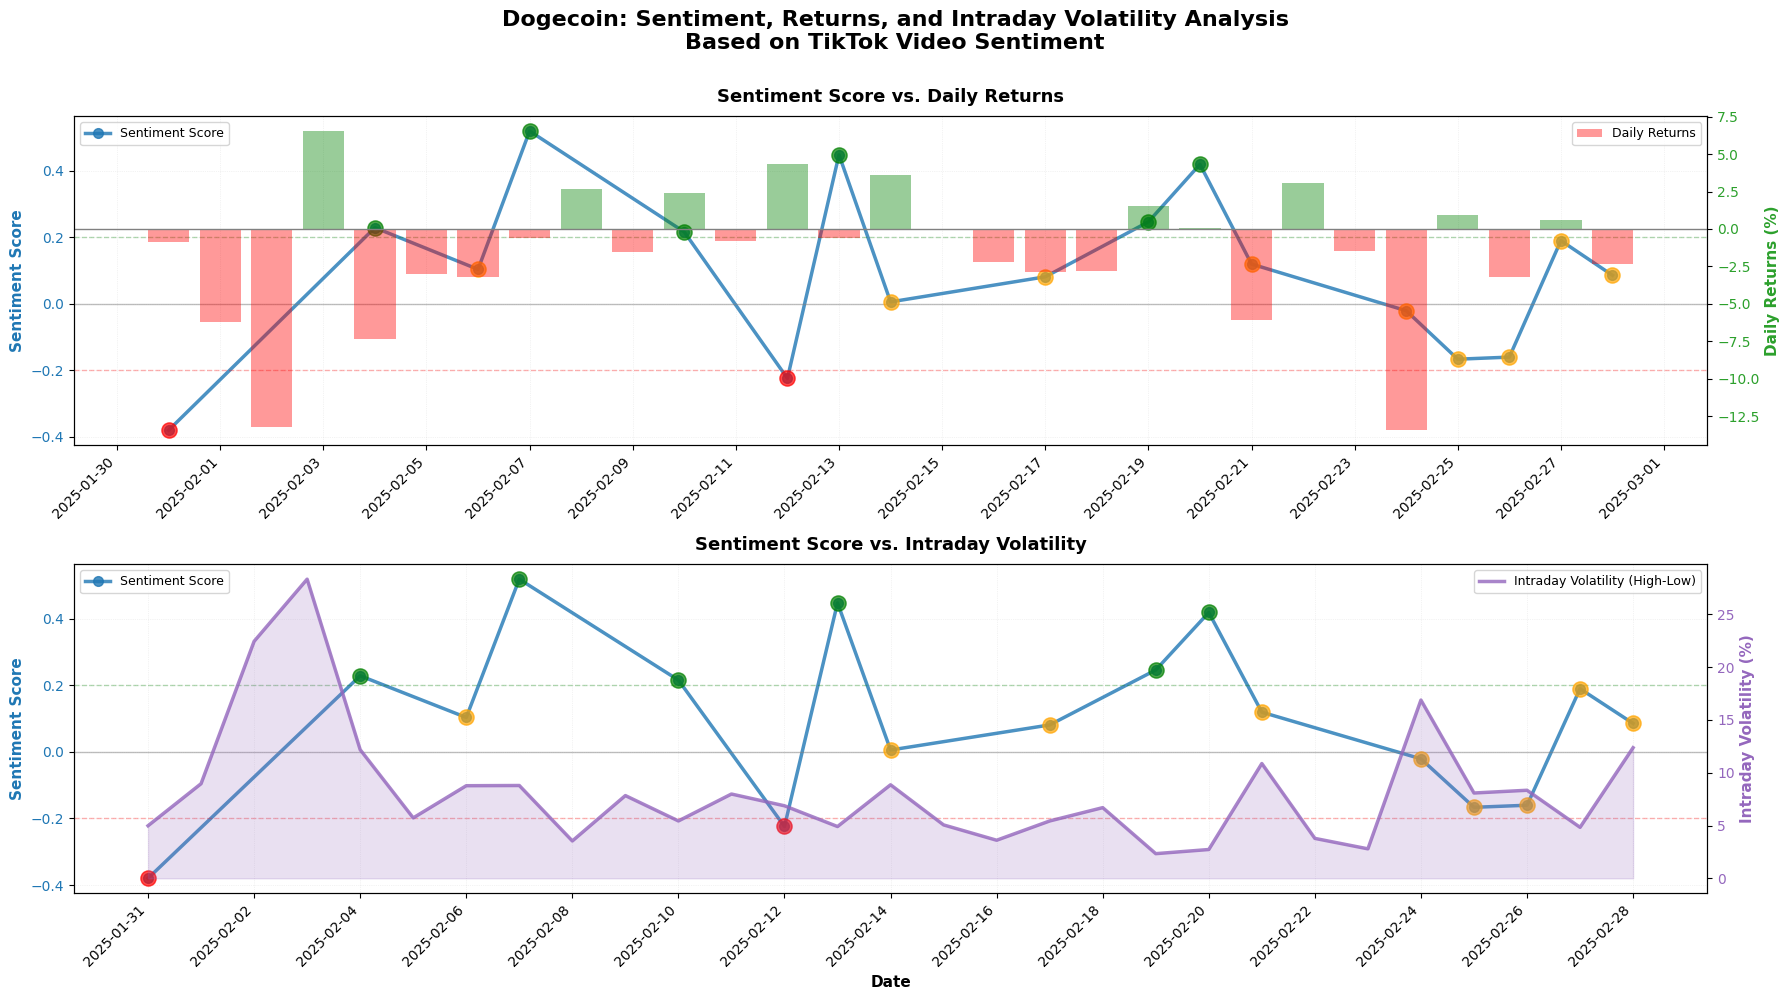


SENTIMENT VS RETURNS AND VOLATILITY ANALYSIS

Sentiment Statistics:
  Mean sentiment:      0.100
  Std deviation:       0.244
  Min sentiment:       -0.380 on 2025-01-31
  Max sentiment:       0.519 on 2025-02-07

Price & Returns Statistics:
  Mean price:          $0.2530
  Std deviation:       $0.0281
  Min price:           $0.2020 on 2025-02-28
  Max price:           $0.3287 on 2025-01-31
  Total return:        -38.56%

  Daily Returns:
    Mean:              -1.590%
    Std deviation:     4.534%
    Min:               -13.441% on 2025-02-24
    Max:               6.540% on 2025-02-03

Intraday Volatility Statistics (High-Low Range):
  Mean intraday vol:   8.253%
  Std deviation:       5.824%
  Min intraday vol:    2.334% on 2025-02-19
  Max intraday vol:    28.331% on 2025-02-03

  Annualized intraday volatility:
    Mean:              157.68%
    Range:             44.58% - 541.26%

Correlation Analysis (on matching dates):
  Sentiment vs Returns:     -0.000 (Weak)
  Sentiment vs 

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

def plot_sentiment_vs_volatility(sentiment_csv: str = './results/sentiment_analysis.csv'):
    """
    Create a dual-axis plot showing sentiment scores vs returns and intraday volatility
    
    Args:
        sentiment_csv: Path to sentiment analysis CSV
    """
    # Load sentiment data
    sentiment_df = pd.read_csv(sentiment_csv)
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
    sentiment_df = sentiment_df.sort_values('date')
    
    # Determine date range for price data
    start_date = sentiment_df['date'].min() - timedelta(days=1)
    end_date = sentiment_df['date'].max() + timedelta(days=1)
    
    print(f"Fetching Dogecoin price data from {start_date.date()} to {end_date.date()}...")
    
    # Fetch Dogecoin price data using yfinance
    try:
        import yfinance as yf
        doge = yf.Ticker("DOGE-USD")
        price_df = doge.history(start=start_date, end=end_date)
        
        if len(price_df) == 0:
            print("⚠ Warning: No price data returned. Cannot calculate volatility.")
            return None, None
        
        print(f"✓ Fetched {len(price_df)} days of Dogecoin price data")
        
        # Remove timezone info
        price_df.index = price_df.index.tz_localize(None)
        
    except Exception as e:
        print(f"Error fetching price data: {e}")
        return None, None
    
    # Calculate daily returns (percentage change from previous close)
    price_df['returns'] = price_df['Close'].pct_change() * 100  # Convert to percentage
    
    # Calculate intraday volatility using Parkinson's estimator (High-Low range)
    # Intraday volatility = (High - Low) / Close * 100 (as percentage)
    price_df['intraday_volatility'] = ((price_df['High'] - price_df['Low']) / price_df['Close']) * 100
    
    # Alternative: Garman-Klass volatility estimator (more sophisticated)
    # GK volatility accounts for both High-Low and Open-Close ranges
    price_df['gk_volatility'] = np.sqrt(
        0.5 * np.log(price_df['High'] / price_df['Low'])**2 - 
        (2*np.log(2) - 1) * np.log(price_df['Close'] / price_df['Open'])**2
    ) * 100
    
    # Use intraday volatility as the main measure
    price_df['volatility'] = price_df['intraday_volatility']
    
    # Calculate annualized intraday volatility
    price_df['volatility_annualized'] = price_df['volatility'] * np.sqrt(365)
    
    print(f"✓ Calculated intraday volatility using High-Low range")
    
    # Filter to sentiment date range
    volatility_df = price_df[price_df.index >= sentiment_df['date'].min()].copy()
    
    # Create figure with two subplots
    fig = plt.figure(figsize=(18, 10))
    
    # Subplot 1: Sentiment Score vs Returns
    ax1 = plt.subplot(2, 1, 1)
    color1 = 'tab:blue'
    ax1.set_ylabel('Sentiment Score', color=color1, fontsize=11, fontweight='bold')
    
    # Plot sentiment
    ax1.plot(sentiment_df['date'], sentiment_df['sentiment_score'], 
             color=color1, linewidth=2.5, marker='o', markersize=7, 
             label='Sentiment Score', alpha=0.8)
    
    # Color code sentiment points
    for idx, row in sentiment_df.iterrows():
        if row['sentiment_score'] > 0.2:
            ax1.scatter(row['date'], row['sentiment_score'], color='green', s=120, zorder=5, alpha=0.7)
        elif row['sentiment_score'] < -0.2:
            ax1.scatter(row['date'], row['sentiment_score'], color='red', s=120, zorder=5, alpha=0.7)
        else:
            ax1.scatter(row['date'], row['sentiment_score'], color='orange', s=120, zorder=5, alpha=0.7)
    
    ax1.axhline(y=0.2, color='green', linestyle='--', alpha=0.3, linewidth=1)
    ax1.axhline(y=-0.2, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.5, linewidth=1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    
    # Returns on secondary axis
    ax1_twin = ax1.twinx()
    color2 = 'tab:green'
    ax1_twin.set_ylabel('Daily Returns (%)', color=color2, fontsize=11, fontweight='bold')
    
    # Plot returns as bars (positive = green, negative = red)
    returns_colors = ['green' if r > 0 else 'red' for r in volatility_df['returns']]
    ax1_twin.bar(volatility_df.index, volatility_df['returns'], 
                 color=returns_colors, alpha=0.4, label='Daily Returns', width=0.8)
    ax1_twin.axhline(y=0, color='gray', linestyle='-', linewidth=1)
    ax1_twin.tick_params(axis='y', labelcolor=color2)
    
    ax1.set_title('Sentiment Score vs. Daily Returns', fontsize=13, fontweight='bold', pad=10)
    ax1.legend(loc='upper left', fontsize=9)
    ax1_twin.legend(loc='upper right', fontsize=9)
    
    # Subplot 2: Sentiment Score vs Intraday Volatility
    ax2 = plt.subplot(2, 1, 2)
    color3 = 'tab:blue'
    ax2.set_ylabel('Sentiment Score', color=color3, fontsize=11, fontweight='bold')
    
    # Plot sentiment
    ax2.plot(sentiment_df['date'], sentiment_df['sentiment_score'], 
             color=color3, linewidth=2.5, marker='o', markersize=7, 
             label='Sentiment Score', alpha=0.8)
    
    # Color code sentiment points
    for idx, row in sentiment_df.iterrows():
        if row['sentiment_score'] > 0.2:
            ax2.scatter(row['date'], row['sentiment_score'], color='green', s=120, zorder=5, alpha=0.7)
        elif row['sentiment_score'] < -0.2:
            ax2.scatter(row['date'], row['sentiment_score'], color='red', s=120, zorder=5, alpha=0.7)
        else:
            ax2.scatter(row['date'], row['sentiment_score'], color='orange', s=120, zorder=5, alpha=0.7)
    
    ax2.axhline(y=0.2, color='green', linestyle='--', alpha=0.3, linewidth=1)
    ax2.axhline(y=-0.2, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5, linewidth=1)
    ax2.tick_params(axis='y', labelcolor=color3)
    ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    
    # Volatility on secondary axis
    ax2_twin = ax2.twinx()
    color4 = 'tab:purple'
    ax2_twin.set_ylabel('Intraday Volatility (%)', color=color4, fontsize=11, fontweight='bold')
    ax2_twin.plot(volatility_df.index, volatility_df['volatility'], 
                  color=color4, linewidth=2.5, label='Intraday Volatility (High-Low)', alpha=0.8)
    ax2_twin.fill_between(volatility_df.index, volatility_df['volatility'], 
                          alpha=0.2, color=color4)
    ax2_twin.tick_params(axis='y', labelcolor=color4)
    
    ax2.set_title('Sentiment Score vs. Intraday Volatility', 
                  fontsize=13, fontweight='bold', pad=10)
    ax2.legend(loc='upper left', fontsize=9)
    ax2_twin.legend(loc='upper right', fontsize=9)
    
    # Format x-axis for all subplots
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add x-axis label to the bottom subplot
    ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
    
    # Overall title
    fig.suptitle('Dogecoin: Sentiment, Returns, and Intraday Volatility Analysis\nBased on TikTok Video Sentiment', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    # Save figure
    output_path = './results/sentiment_vs_volatility.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✓ Plot saved to: {output_path}")
    
    plt.show()
    
    # Merge data for correlation analysis
    merged_df = sentiment_df.set_index('date')[['sentiment_score']].join(
        volatility_df[['Close', 'returns', 'volatility', 'volatility_annualized']], 
        how='inner'
    )
    merged_df = merged_df.rename(columns={'Close': 'price'})
    
    # Print comprehensive statistics
    print("\n" + "="*80)
    print("SENTIMENT VS RETURNS AND VOLATILITY ANALYSIS")
    print("="*80)
    
    print(f"\nSentiment Statistics:")
    print(f"  Mean sentiment:      {sentiment_df['sentiment_score'].mean():.3f}")
    print(f"  Std deviation:       {sentiment_df['sentiment_score'].std():.3f}")
    print(f"  Min sentiment:       {sentiment_df['sentiment_score'].min():.3f} on {sentiment_df.loc[sentiment_df['sentiment_score'].idxmin(), 'date'].date()}")
    print(f"  Max sentiment:       {sentiment_df['sentiment_score'].max():.3f} on {sentiment_df.loc[sentiment_df['sentiment_score'].idxmax(), 'date'].date()}")
    
    print(f"\nPrice & Returns Statistics:")
    print(f"  Mean price:          ${volatility_df['Close'].mean():.4f}")
    print(f"  Std deviation:       ${volatility_df['Close'].std():.4f}")
    print(f"  Min price:           ${volatility_df['Close'].min():.4f} on {volatility_df['Close'].idxmin().date()}")
    print(f"  Max price:           ${volatility_df['Close'].max():.4f} on {volatility_df['Close'].idxmax().date()}")
    print(f"  Total return:        {((volatility_df['Close'].iloc[-1] - volatility_df['Close'].iloc[0]) / volatility_df['Close'].iloc[0] * 100):.2f}%")
    
    returns_clean = volatility_df['returns'].dropna()
    if len(returns_clean) > 0:
        print(f"\n  Daily Returns:")
        print(f"    Mean:              {returns_clean.mean():.3f}%")
        print(f"    Std deviation:     {returns_clean.std():.3f}%")
        print(f"    Min:               {returns_clean.min():.3f}% on {returns_clean.idxmin().date()}")
        print(f"    Max:               {returns_clean.max():.3f}% on {returns_clean.idxmax().date()}")
    
    print(f"\nIntraday Volatility Statistics (High-Low Range):")
    vol_clean = volatility_df['volatility'].dropna()
    if len(vol_clean) > 0:
        print(f"  Mean intraday vol:   {vol_clean.mean():.3f}%")
        print(f"  Std deviation:       {vol_clean.std():.3f}%")
        print(f"  Min intraday vol:    {vol_clean.min():.3f}% on {vol_clean.idxmin().date()}")
        print(f"  Max intraday vol:    {vol_clean.max():.3f}% on {vol_clean.idxmax().date()}")
        
        vol_ann = volatility_df['volatility_annualized'].dropna()
        print(f"\n  Annualized intraday volatility:")
        print(f"    Mean:              {vol_ann.mean():.2f}%")
        print(f"    Range:             {vol_ann.min():.2f}% - {vol_ann.max():.2f}%")
    
    if len(merged_df) > 1:
        print(f"\nCorrelation Analysis (on matching dates):")
        corr_returns = merged_df['sentiment_score'].corr(merged_df['returns'])
        corr_vol = merged_df['sentiment_score'].corr(merged_df['volatility'])
        
        print(f"  Sentiment vs Returns:     {corr_returns:+.3f}", end="")
        if abs(corr_returns) > 0.7:
            print(f" (Strong {'positive' if corr_returns > 0 else 'negative'})")
        elif abs(corr_returns) > 0.4:
            print(f" (Moderate {'positive' if corr_returns > 0 else 'negative'})")
        else:
            print(f" (Weak)")
        
        print(f"  Sentiment vs Volatility:  {corr_vol:+.3f}", end="")
        if abs(corr_vol) > 0.7:
            print(f" (Strong {'positive' if corr_vol > 0 else 'negative'})")
        elif abs(corr_vol) > 0.4:
            print(f" (Moderate {'positive' if corr_vol > 0 else 'negative'})")
        else:
            print(f" (Weak)")
        
        # Analyze sentiment impact on next-day returns and volatility (lag analysis)
        if len(merged_df) > 2:
            merged_df['next_day_returns'] = merged_df['returns'].shift(-1)
            merged_df['next_day_volatility'] = merged_df['volatility'].shift(-1)
            corr_lag_returns = merged_df['sentiment_score'].corr(merged_df['next_day_returns'])
            corr_lag_vol = merged_df['sentiment_score'].corr(merged_df['next_day_volatility'])
            print(f"  Sentiment vs Next-day Returns: {corr_lag_returns:+.3f} (Predictive power)")
            print(f"  Sentiment vs Next-day Vol:     {corr_lag_vol:+.3f} (Predictive power)")
        
        # High/Low sentiment analysis
        high_sentiment = merged_df[merged_df['sentiment_score'] > 0.2]
        low_sentiment = merged_df[merged_df['sentiment_score'] < -0.2]
        
        if len(high_sentiment) > 0 and len(low_sentiment) > 0:
            print(f"\nSentiment Impact Analysis:")
            print(f"  High Sentiment Days (>0.2):")
            print(f"    Avg returns:       {high_sentiment['returns'].mean():+.3f}%")
            print(f"    Avg volatility:    {high_sentiment['volatility'].mean():.3f}%")
            print(f"\n  Low Sentiment Days (<-0.2):")
            print(f"    Avg returns:       {low_sentiment['returns'].mean():+.3f}%")
            print(f"    Avg volatility:    {low_sentiment['volatility'].mean():.3f}%")
            print(f"\n  Differences:")
            print(f"    Returns diff:      {high_sentiment['returns'].mean() - low_sentiment['returns'].mean():+.3f}%")
            print(f"    Volatility diff:   {high_sentiment['volatility'].mean() - low_sentiment['volatility'].mean():+.3f}%")
    
    print("="*80)
    
    # Save detailed results to CSV
    output_csv = './results/sentiment_volatility_analysis.csv'
    merged_df.to_csv(output_csv)
    print(f"\n✓ Detailed data saved to: {output_csv}")
    
    return sentiment_df, volatility_df

# Run the volatility analysis
print("="*80)
print("CREATING SENTIMENT VS RETURNS AND VOLATILITY VISUALIZATION")
print("="*80 + "\n")

sentiment_data, volatility_data = plot_sentiment_vs_volatility(
    sentiment_csv='./results/sentiment_analysis.csv'
)

## Summary

### What This Notebook Provides:

1. **CLIPVideoSentimentAnalyzer**: CLIP-based visual sentiment analysis for cryptocurrency videos
2. **Frame Extraction**: Uses OpenCV to extract frames from videos
3. **Zero-Shot Classification**: CLIP analyzes frames against sentiment labels
4. **Batch Processing**: Processes multiple videos and saves results to CSV

### Current Features:

✅ **CLIP-Based Analysis**: Uses OpenAI's CLIP model for visual sentiment understanding  
✅ **Frame Sampling**: Extracts 5 frames uniformly distributed across each video  
✅ **Zero-Shot Learning**: No training needed - CLIP understands "bullish", "bearish", "neutral" concepts  
✅ **Robust Fallback**: Uses filename heuristics if frame extraction fails  
✅ **CSV Output**: Results saved with sentiment scores, classifications, and confidence levels  

### How It Works:

1. **Extract Frames**: Samples 5 frames uniformly from each video
2. **CLIP Analysis**: Compares each frame against sentiment labels:
   - "positive cryptocurrency news, bullish market, growth, moon, pump"
   - "negative cryptocurrency news, bearish market, decline, crash, dump"
   - "neutral cryptocurrency discussion, stable market, sideways"
3. **Score Calculation**: Sentiment = P(positive) - P(negative)
4. **Classification**: POSITIVE (>0.2), NEGATIVE (<-0.2), or NEUTRAL

### Data Requirements:

**Videos**: Place in `./videos/` with date-based names:
   - `2024-01-15.mp4`, `20240115.mp4`, or `2024_01_15.mp4`

### Expected Outputs:
- `sentiment_analysis.csv`: Contains date, sentiment_score, sentiment_class, confidence, method, num_frames_analyzed

### Dependencies:
```bash
pip install torch transformers opencv-python pandas numpy
```

### Next Steps:

To enhance the analysis, you can:
1. Add audio transcription (Whisper) for speech sentiment
2. Include OCR for visible text in videos
3. Combine multiple modalities for more robust predictions
4. Use larger CLIP models for better accuracy
5. Fine-tune on cryptocurrency-specific content

The current CLIP-based approach provides a solid foundation for visual sentiment analysis!
